### Fire Weather Prep
_Updated Jan 2016_ <p>
The goal of this notebook is to leverage RAWS data to generate fire weather inputs for LANDIS across the landscape. The notebook imports from FireWeatherIndex_Calculations.py, a script originially written by Louise Loudermilk to convert time series of daily data into the LANDIS input files required by the Dynamic Fire and Fuels System extension. Here, we modify this script and set up a work flow to process RAWS data by year.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime, math
from scipy import stats
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations
DFFSDir = 'C:/Research/Dinkey_Creek/DFFS_Data/FireWeather/'

#### I chose to represent 
fire weather using RAWS data from each of the three fire regions represented in our simulation. The fire regions were defiend by Shuang et al., 2015, and were defined using elevation bins. FR1 is the lowest elevation region, and RAWS data from Batterson California were used to generate the fire weather (elvation = 963 m). FR2 is the middle elevation region, with fireweather derived from the Dinkey California station (elevation = 1727 m). FR3 is the high elevation region, and I chose the High Sierra California RAWS station (elevation = 2256 m). All stations are fairly proximal to one another, and roughly represent the middle elevation of their respective fire regions.

RAWS data fills bad values with a mask (I chose -9999). That means we need to remove those rows before the fireweather prep script can operate on the downloaded data.

The DFFS in LANDIS-II treats wind direction as the direction the wind is blowing _to_, and consequently we need to modify wind direction by 180 degrees in order to convert the RAWS data, as most climatological stations report the wind direction as the direction that the wind is blowing _from_.

The current state of Louise's script needs some specific data formatting.. since some of the RAWS data starts or ends in the middle of  a year, I clipped the inputs to start in 2002 and end in 2014.. that way only complete years (mostly just that the data start on the 1st and end on the 365th day of year) are used in the analysis -- I Think this is only a problem because of the way the script assesses season, and think it might be worth modernizing the script to leverage Pandas and timestamps...

In [2]:
# Quick function to flip the wind direction from RAWS to account for the difference in how directions are
# handled between RAWS and the DFFS.

def adjustWindAz(windDir):
    if math.degrees(math.radians(windDir) + math.radians(180)) > 360:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180)) - 360
    else:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180))
    return windDir_adj
        
# Function to clean up the mask values and data types from the RAWS outputs. Note, here the RAWS ASCII Downloads
# have to be manually edited to conform to the sample input from Louise's script in order to run.

def cleanRaws(formattedRawsData, maskValue, yearStart, yearStop, cleanedRawsData):
    rawsdata = pd.read_csv(formattedRawsData)
    rawsdata[rawsdata == maskValue] = np.nan
    rawsdata = rawsdata.dropna()
    rawsdata.Juliandate = rawsdata.Juliandate.astype(int)
    print 'Converting wind directions.....'
    rawsdata.windazimuth = rawsdata.windazimuth.apply(adjustWindAz) # wind direction adjustment
    rawsdata.windazimuth = rawsdata.windazimuth.astype(int)
    rawsdata.relativehumidity = rawsdata.relativehumidity.astype(int)
    rawsdata = rawsdata[rawsdata.year > yearStart]
    rawsdata = rawsdata[rawsdata.year < yearStop]
    rawsdata.windspeed = rawsdata.windspeed * 3.6 # Convert m/s to km/h

    rawsdata.to_csv(cleanedRawsData, index = False)
    


### Fire weather generation
I'm going to step through the fire weather generation for two main branches of the simulations at Dinkey: historic and severe fire weather. The overall premise here is that historic fire weather be derived from RAWS data over the past ~10-15 years, and gathered from RAWS stations that 1) are proximal to the fire regions being simulation at Dinkey, and 2) roughly represent the climate distribution ranges we see across the Dinkey landscape. The severe fire weather will be generated from a subset of the historic weather, which was associated with large fires (specifically the Rim and Rough fires).
#### Historic fire weather
Generation of the fire weather used in the historic (non-severe) Dinkey Creek runs. More information is available in the Dinkey Creek notebook, specifically related to the result of the fire weather on the runs, etc.

In [3]:
# Clean up RAWS raw data and generate FW inputs for the three fire regions

cleanRaws(DFFSDir + 'BATTERSON_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'FR1_RawsWeather.csv')
cleanRaws(DFFSDir + 'DINKEY_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR2_RawsWeather.csv')
cleanRaws(DFFSDir + 'HIGH_SIERRA_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR3_RawsWeather.csv')


# Run Louise's script on the three fire regions input RAWS generated previously.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeather.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region +'_FireWeather.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeather.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeather.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeather.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeyFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()


Converting wind directions.....
Converting wind directions.....
Converting wind directions.....
No. days being evaluated  4644

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2237
No. days being evaluated  4725

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  1576
No. days being evaluated  4356

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2391


FFMC   BUI   WSV  WINDDir  FWIBin
Ecoregion Season                                   
FR1       fall     190   190   190      190     190
          spring    73    73    73       73      73
          summer  1974  1974  1974     1974    1974
FR2       fall      26    26    26       26      26
          spring     1     1     1        1       1
          summer  1549  1549  1549     1549    1549
FR3       fall     238   238   238      238     238
          spring    79    79    79       79      79
          summer  2074  2074  2074     2074    2074

#### We need to hack 
the weather data a bit to allow fires in Spring for both FR2 and FR3. Realistically, we don't expect these regions to burn in the spring, however LANDIS throws errors if we want to say some regions can burn in the spring and some can't. Our solution here is to create some fake fire weather data for FR2 and FR3 with sufficiently high foliar moisture to effectively keep fires from (at least) propagating in the Spring. 

Depending on adjustments to the fire weather data, this step might not be necessary -- however, we're adding 10 draws to an enormous number of fire weather entries, so the impact is negligible. 

In [4]:
FFMC = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
BUI = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
WSV = [0,0,0,0,0,0,0,0,0,0]
WDR = [0,0,0,0,0,0,0,0,0,0]
FWIBin = [1,1,1,1,1,1,1,1,1,1]
Season = ['spring','spring','spring','spring','spring',
          'spring','spring','spring','spring','spring']
Ecoregion = ['FR2','FR2','FR2','FR2','FR2',
             'FR3','FR3','FR3','FR3','FR3']
FW_to_Add = pd.DataFrame(dict(FFMC = FFMC, BUI = BUI, WSV = WSV, 
                              WINDDir = WDR, FWIBin = FWIBin, 
                              Season = Season, Ecoregion = Ecoregion))

DinkeyFW_h = pd.concat((DinkeyFW, FW_to_Add))
DinkeyFW_h.to_csv(DFFSDir + 'DinkeyFW_h.csv', index = False)

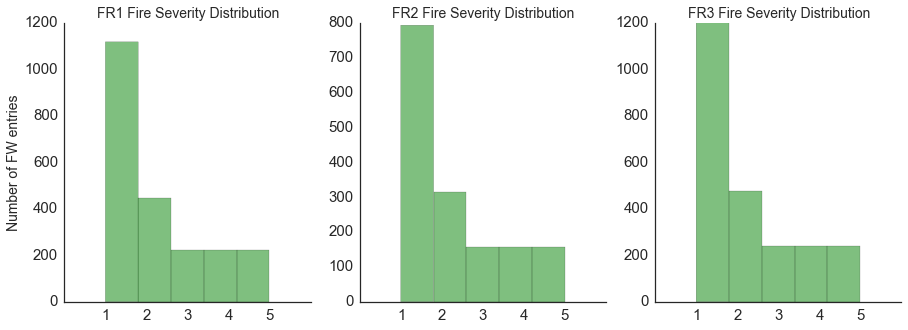

In [208]:
f, ax = plt.subplots(1,3, figsize =(15,5))
idx = 0
axs = f.axes
for Eco in np.unique(DinkeyFW_h.Ecoregion):
    ax = axs[idx]
    toPlot = DinkeyFW_h[DinkeyFW_h.Ecoregion == Eco]
    toPlot.FWIBin.hist(ax = ax, bins = 5, facecolor = 'green', alpha = 0.5)
    ax.set_title(Eco + ' Fire Severity Distribution', fontsize = 14)
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['','1','2','3','4','5',''])
    #ax.set_ylim([0,1100])
    ax.grid('off')
    if idx == 0:
        ax.set_ylabel('Number of FW entries', fontsize = 14)
    
    idx = idx + 1
sns.set_style('white')
sns.despine()

#### Severe Fire weather
Our first cut was to take data from the Rim fire and the Rough fire, and drive the fire weather based on those time series. The Rim fire data I grabbed from Smith Peak -- chose to include the entire year, given the whole period was fairly dry, and obviously resulted in a large amount of dry fuel. The Rough fire data we had to grab from a portable station (SNF01), by contacting the Sierra parks people. The format of the Rough fire data is pretty old school, lots of conversions to take care of in a one-off fashion before we can work them into FW format.

In [6]:
# Handle the SNF01 data
SNF01 = pd.read_csv(DFFSDir + 'SNF01_Portable-2016-1-19-13-46-28_formatted.csv')
SNF01['Date'] = pd.to_datetime(SNF01.DateTime)
SNF01.index = SNF01.Date
SNF01_ATC = (SNF01.ATF - 32) * 5.0/9.0 # Convert deg F to deg C
SNF01_WS_mps = SNF01.WSM * 0.44704 # Convert miles/h to meters/s
SNF01_P_mm = SNF01.RNIN * 25.4
RoughFW_h = pd.DataFrame(dict(year = SNF01.index.year, Juliandate = SNF01.index.dayofyear,
                           temp = SNF01_ATC, windspeed = SNF01_WS_mps, windazimuth = SNF01.WDD,
                           relativehumidity = SNF01.RHP, precip_mm = SNF01_P_mm))
# At this point, the SNF01 data resembles other 'formatted' RAWS inputs, in terms of column headers and units,
# but its hourly as opposed to daily. 
RoughFW_h = RoughFW_h[RoughFW_h.Juliandate < 268]
RoughFW = RoughFW_h.groupby(['year','Juliandate']).mean()

# Something goes awry with the precip, maybe ash or something else blew into the gauge. Other
# met data shows no precip during this time, so I set it to 0 for the sake of processing.
RoughFW.precip_mm = 0
RoughFW.reset_index().to_csv(DFFSDir + 'SNF01_Portable_FORMATTED.csv', 
                             columns = ['year','Juliandate','temp','windspeed',
                                     'windazimuth','relativehumidity','precip_mm'],index = False)
cleanRaws(DFFSDir + 'SNF01_Portable_FORMATTED.csv',-9999, 
          2000, 2016, DFFSDir + 'SNF01_RawsWeather.csv')
SNF01FW = pd.read_csv(DFFSDir + 'SNF01_RawsWeather.csv')

Converting wind directions.....


The SNF01 station was only operational in the Rough fire area for ~ 30 days. Further, a lot of the data required by LANDIS to generate information about curing of fuels, and the BUI, wasn't collected simply because the station was not in place prior the fire's ignition. 

In [7]:
# Clean up RAWS raw data and generate FW inputs for the three fire regions -- This is just
# the same data for each fire region, saved under three different file names.

cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999, 
          2000, 2016, DFFSDir + 'FR1_RawsWeatherS.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2016, DFFSDir + 'FR2_RawsWeatherS.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2016, DFFSDir + 'FR3_RawsWeatherS.csv')

# Run Louise's script on the three fire regions input RAWS data.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeatherS.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region + '_FireWeatherS.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeatherS.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeatherS.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeatherS.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeySevereFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()

Converting wind directions.....
Converting wind directions.....
Converting wind directions.....
No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  237
No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  245
No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  247


FFMC  BUI  WSV  WINDDir  FWIBin
Ecoregion Season                                 
FR1       fall      29   29   29       29      29
          spring    19   19   19       19      19
          summer   189  189  189      189     189
FR2       fall      29   29   29       29      29
          spring    26   26   26       26      26
          summer   190  190  190      190     190
FR3       fall      29   29   29       29      29
          spring    28   28   28       28      28
          summer   190  190  190      190     190

### Finally a Win
Fire weather generated from the Rim fire (using 2013 data from Smith Peak RAWS) created a much more aggressive fire severity profile across Dinkey Creek. To flesh out the fire weather options more, I need to add in some RAWS data from the Rough fire from the Sierras in 2015. This is proving difficult, the stations I would want to use were portable, and placed in / near the fire footprint in July following the ignition. Park Ridge and Pinehurst RAWS stations currently have their own issues as well. Pinehurst only has data for the fisrt half of 2015, and Park Ridge weather shows low wind speeds, and no significant difference in mean air T relative to the Dinkey RAWS for example. 

### Alternate approach
Given that we only have one year of fire weather draws, and that LANDIS-II moved away from the mean and variance approach to dynamically build distributions, I'm going to use 2013 data from the Rim fire to generate a distribution and tack on 2 more years of weather data that have similar met values. The intent here is to increase the fire weather draws for finer granularity in severity map generation and simply to reduce the redundancy of fire weather draws. 

Converting wind directions.....


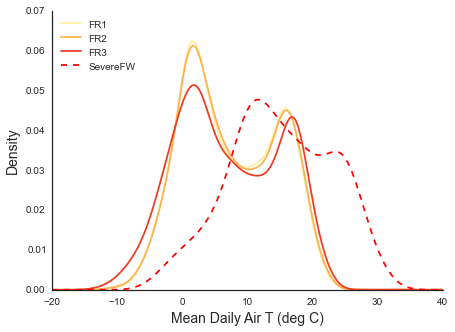

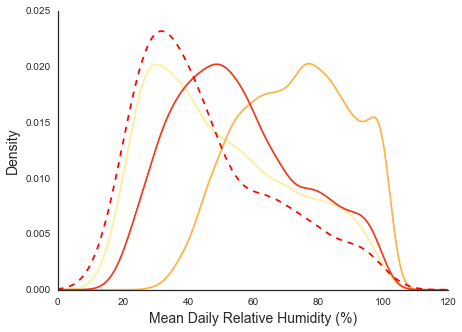

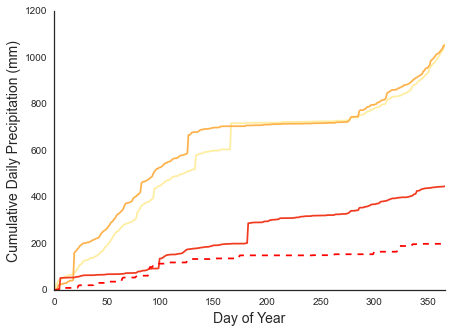

In [8]:
# Start by importing the Smith Peak RAWS data -- our best best for the Rim fire weather
# Clean it up and save the resulting inputs to the fire weather prep -- then 
# read it into a dataframe for visualization and mucking with.
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'Severe_RawsWeather.csv')
severeFW = pd.read_csv(DFFSDir + 'Severe_RawsWeather.csv')
severeFW['FR'] = 'All' # Note here, I'm using the same fire weather for all fire regions ...

# Lets also read in FW for the three other regions so we can create distributions of 
# historic and 'severe' FW -- a figure that will probably be needed to show in the
# MS that results from this analysis.
FR1_historic = pd.read_csv(DFFSDir + 'FR1_RawsWeather.csv')
FR2_historic = pd.read_csv(DFFSDir + 'FR2_RawsWeather.csv')
FR3_historic = pd.read_csv(DFFSDir + 'FR3_RawsWeather.csv')
FR1_historic['FR'] = 'FR1'
FR2_historic['FR'] = 'FR2'
FR3_historic['FR'] = 'FR3'

historicFW = pd.concat([FR1_historic, FR2_historic, FR3_historic])

# fireregion colors
FireregionFC = ['#ffeda0', '#feb24c', '#f03b20']

# Start by displaying distributions for the params of interest
FWParams = ['temp','windspeed','relativehumidity','precip_mm']

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    toPlot.temp.plot(ax = ax, kind = 'kde', color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.temp.plot(ax = ax, kind = 'kde', ls = '--', color = 'red')
ax.set_xlim([-20, 40])
ax.set_xlabel('Mean Daily Air T (deg C)', fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
ax.legend(['FR1','FR2','FR3','SevereFW'], loc = 'upper left')
sns.despine()

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    toPlot.relativehumidity.plot(ax = ax, kind = 'kde', color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.relativehumidity.plot(ax = ax, kind = 'kde', ls = '--', color = 'red')
ax.set_xlim([0, 120])
ax.set_xlabel('Mean Daily Relative Humidity (%)', fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
sns.despine()

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    # this mess just uses pandas groupby to generate a mean daily precip for all 14 years of RAWS
    # data for a given fire region, and accumulates those mean values over time.
    toPlot.groupby('Juliandate').precip_mm.mean().cumsum().plot(ax = ax, color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.precip_mm.cumsum().plot(ax = ax, ls = '--', color = 'red')
ax.set_xlabel('Day of Year', fontsize = 14)
ax.set_ylabel('Cumulative Daily Precipitation (mm)', fontsize = 14)
sns.despine()




### What about the wind?
We know that the wind directions between the RAWS data from stations throughout Dinkey and the stations from which we're generating the 'severe' fire weather have got to be different. That may have some implications for severity if the 'severe' fire weather is complimenting fire extent or severity simply by change, via interactions with terrain. It is not reasonable in this case to think that there is a 'good' representation of local wind used in the DFFS so far given the RAWS stations locations. Therefore, I'll check for a significant difference between wind directions in both the severe and historic FW scenarios, and if one exists I'll swap the wind directions from the historic with the severe.. so wind direction will not be a confounding factor moving forward.

Hope you're not colorblind


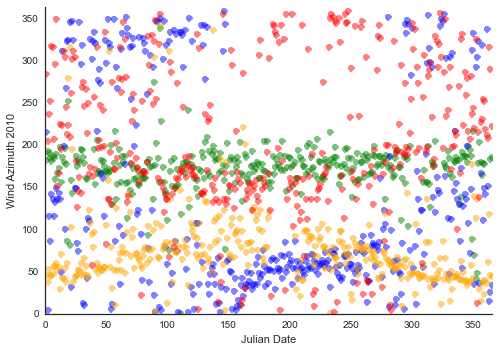

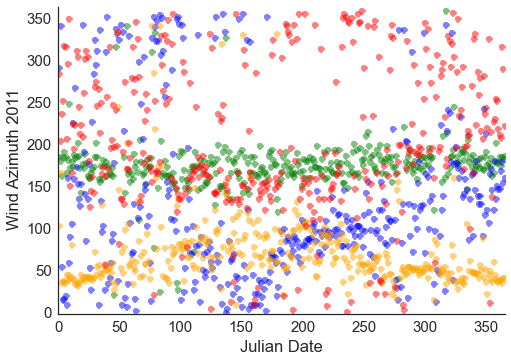

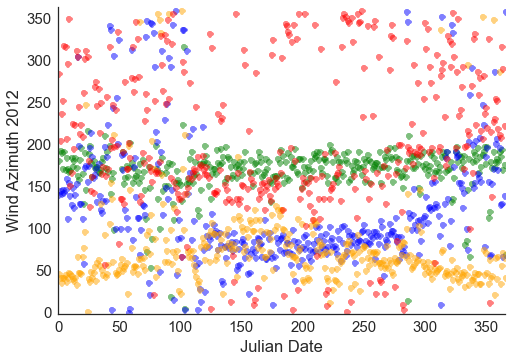

In [9]:
regionColors = ['green','blue','orange']
for year in [2010, 2011, 2012]:
    plt.figure()
    historicFW_y = historicFW[historicFW.year == year]
    historicAZ = historicFW_y
    idx = 0
    for FR in ['FR1','FR2','FR3']:
        historicFR = historicAZ[historicAZ.FR == FR]
        plt.plot(historicFR.Juliandate, historicFR.windazimuth, 'o', color = regionColors[idx], alpha = 0.5)
        idx = idx + 1
    plt.plot(severeFW.Juliandate, severeFW.windazimuth, 'or', alpha = 0.5)

    plt.xlim([0,365])
    plt.ylim([0,365])
    sns.despine()
    plt.xlabel('Julian Date')
    plt.ylabel('Wind Azimuth ' + str(year))
    sns.set_context('notebook', font_scale=1.5)
    
print '''Hope you're not colorblind'''


### Creating synthetic observations of severe fire based on Rim fire RAWS Data
Given the issues with wind direction, moving forward I'll grab distributions by DOY for wind direction and apply them to the fire weather on a per fire region basis. That means the wind azimuth (not speed) will come from the same set of distributions for both historic and severe fire weather.

I've looked at fitting gaussians to the distribution of fire weather drivers (see below), but think it might be a little overpowered for the task at hand. I'm going to create weekly bins, assess the mean and std of each bin, and generate years of data using that approach. Its defensible and we dont have to slap any gaussian mixing model text into the methods.

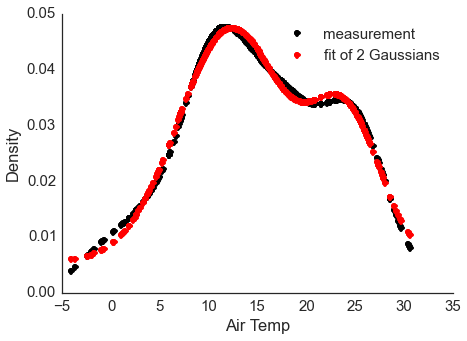

In [10]:
from scipy import optimize

kernel = stats.gaussian_kde(severeFW.temp)

yy = kernel(severeFW.temp)
xx = severeFW.temp
data = pd.DataFrame(dict(temps = xx, density = yy))

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + offset)

def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return three_gaussians(x, h1, c1, w1, h2, c2, w2, 0,0,1, offset)

errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2
guess2 = [0.05, 10, 5, 0.04, 27, 5, 0]  # I removed the peak I'm not too sure about
optim2, success = optimize.leastsq(errfunc2, guess2[:], args=(data.temps, data.density))
f, ax = plt.subplots(1,1, figsize =(7,5))
ax.plot(data.temps, data.density, 'ok', label='measurement')
ax.plot(data.temps, two_gaussians(data.temps, *optim2),
    'or', label='fit of 2 Gaussians')
ax.legend(loc='best')
ax.set_xlabel('Air Temp')
ax.set_ylabel('Density')
sns.despine()

#plt.plot(data.temps, two_gaussians(data.temps, *optim2), 'or')


#### Ghetto distribution generation, mostly empirical
I'm using a weekly kernel and producing random draws from a gaussian with known mean and variance. For each week, I'll generate 7 draws, and assign each draw a juliandate. On a year by year basis, we can then create 12 years of data for our severe FW to match the density of draws from our historic FW.

In [140]:
import math
from random import gauss
# iterate over the weeks of the year, and calculate the mean and variance
# of a climate variable in our weather data. Then draw from that week's
# gaussian distribution (with given mean and var) to generate 7 new days of data
def genFWData(inputdata, variable):
    outputvar = []
    # Calcualte the mean 
    grouped_input = inputdata.groupby(inputdata.Juliandate).mean().reset_index()

    for k in range(121):
        kernelstart = np.arange(1,366,3)[k]
        if k == 121:
            kernelstop = 366
        else:
            kernelstop = np.arange(1,366,3)[k+1]
        maxdays = 365
        bin_days = grouped_input[(grouped_input.Juliandate >= kernelstart) & (grouped_input.Juliandate < kernelstop)]
        varmean = bin_days[variable].mean()
        varvar = bin_days[variable].var()

        for i in range(3):
            # I do some odd stuff with precip.. because no matter what, since we throw away negative
            # draws, and 3 days have the chance of raining if just one day showed rain in the original
            # data, we are going to overestimate precip. I built in a 15% chance that it just doesnt rain..
            # this was empirically derived, to result in half the years of data showing greater precip, and
            # half the years showing less precip.
            if variable == 'precip_mm':
                rain_check = np.random.normal(0, 1)
                if rain_check > -1:
                    outputvar.append(gauss(varmean, math.sqrt(varvar))) 
                else:
                    outputvar.append(0)

            else:
                outputvar.append(gauss(varmean, math.sqrt(varvar)))    
        outputData = pd.DataFrame(dict(outvar = outputvar[:365]))
    return outputData


#### As a quick test
Lets plot the air temperature distribution from the above 2 gaussian approach, on top of the distribution generated using this 7 day kernel mean and variance generator. Generally speaking the 2 gaussian model captures the highs and lows better than a weekly kernel estimate, but the differences are minimal and due to the fact that we are basically averaging or smoothing over a 7 day period. The bigest plus, its far simpler to explain and implement. Given the performance of the two approaches and their complexity, I'm sticking with the kernel operator, because _parsimony is a way of life_.

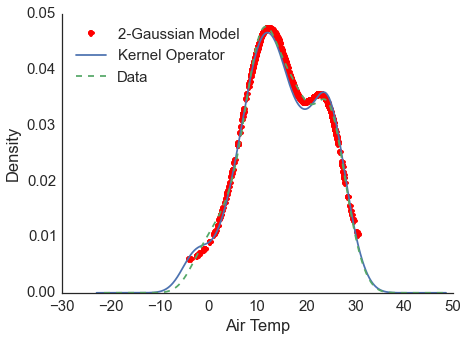

In [153]:
f, ax = plt.subplots(1,1, figsize =(7,5))
ax.plot(data.temps, two_gaussians(data.temps, *optim2), 'or')
kernelTemp = genFWData(severeFW, 'temp')
kernelTemp.plot(ax = ax, kind = 'kde')
severeFW.temp.plot(ax = ax, kind = 'kde', ls = '--')
ax.legend(['2-Gaussian Model','Kernel Operator', 'Data'], 
          loc = 'upper left', fontsize = 15)
ax.set_xlabel('Air Temp')
sns.despine()
sns.set_context('notebook', font_scale=1.5)

#### Building out severe fire weather using the kernel operator to create synthetic years

In [239]:
count = 0
for FR in np.unique(historicFW.FR):
    for year_idx in np.unique(historicFW.year):
        if count == 0:
            finalFW = pd.DataFrame(dict(Juliandate = np.arange(1,366,1)))
            finalFW['year'] = year_idx
            finalFW['temp'] = genFWData(severeFW, 'temp')
            finalFW['windspeed'] = genFWData(severeFW, 'windspeed')
            # Make sure each fire region leverages its own wind directions as distributions
            # for the severe fire weather
            thisFR = historicFW[historicFW.FR == FR]
            finalFW['windazimuth'] = genFWData(thisFR, 'windazimuth')
            finalFW['relativehumidity'] = genFWData(severeFW, 'relativehumidity')
            finalFW['precip_mm'] = genFWData(severeFW, 'precip_mm')
            finalFW['FR'] = FR
        else:
            kernelFW = pd.DataFrame(dict(Juliandate = np.arange(1,366,1)))
            kernelFW['year'] = year_idx
            kernelFW['temp'] = genFWData(severeFW, 'temp')
            kernelFW['windspeed'] = genFWData(severeFW, 'windspeed')
            thisFR = historicFW[historicFW.FR == FR]
            kernelFW['windazimuth'] = genFWData(thisFR, 'windazimuth')
            kernelFW['relativehumidity'] = genFWData(severeFW, 'relativehumidity')
            kernelFW['precip_mm'] = genFWData(severeFW, 'precip_mm')
            kernelFW['FR'] = FR

            finalFW = pd.concat([finalFW,kernelFW])
        count = count + 1

# sanity checking based on reasonable bounds
for var in ['windspeed','relativehumidity','precip_mm']:
    finalFW[var][finalFW[var] < 0] = 0
    finalFW[var][finalFW[var] > 100] = 0
    
# Apply some smoothing (rolling median) to the relative humidity data, to avoid excessively
# low and unrealistic values
finalFW['relativehumidity'] = pd.rolling_median(finalFW['relativehumidity'], 3)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Time to check the fake data...
and make sure the synthetic years fall within reasonable trends of the severe fire weather year from the Rim fire in 2013. In doing this, I recognized that we need to add in some data bounds .. making sure the observations we're generating are actually plausible. Negative precip, for instance, just isn't -- also given that I'm creating a gaussian distribution with mu and sigma from only 3 days of data, and applying draws from that distribution to 3 consecutive days, certain observations that are lognormal (like precip, where generally it doesnt rain much but may rain a lot) tend to be bias high. To account for this, I built in a 'raincheck' parameter, basically building in a 15% chance that it simply won't rain for a given day, regardless of the mu and sigma for that 3 day window. Making up data!

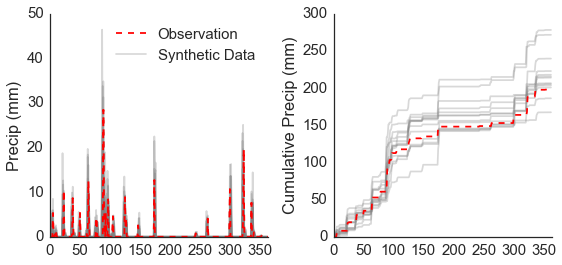

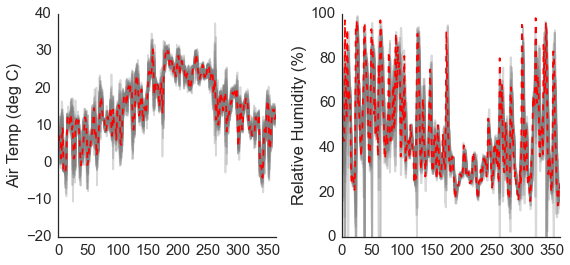

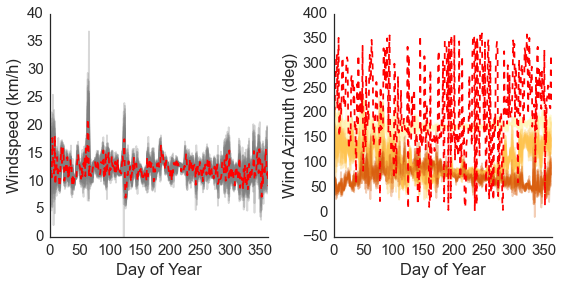

In [241]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(9,4))
plt.subplots_adjust(wspace = 0.3)
severeFW.precip_mm.plot(ax = ax1, color = 'red', ls = '--')
for year  in np.unique(finalFW.year):    
    finalFWY = finalFW[finalFW.year == year]
    for FR in np.unique(finalFWY.FR):
        finalFWYfr = finalFWY[finalFWY.FR == FR]
    finalFWYfr.precip_mm.plot(ax = ax1, color = 'grey', alpha = 0.3)
    finalFWYfr.precip_mm.cumsum().plot(ax = ax2, color = 'grey', alpha = 0.3)
severeFW.precip_mm.plot(ax = ax1, color = 'red', ls = '--')
severeFW.precip_mm.cumsum().plot(ax = ax2, color = 'red', ls = '--')
ax1.legend(['Observation','Synthetic Data'])
ax1.set_ylabel('Precip (mm)')
ax2.set_ylabel('Cumulative Precip (mm)')
sns.despine()

f, (ax1, ax2) = plt.subplots(1,2, figsize =(9,4))
plt.subplots_adjust(wspace = 0.3)
for year  in np.unique(finalFW.year):
    finalFWY = finalFW[finalFW.year == year]
    finalFWY.temp.plot(ax = ax1, color = 'grey', alpha = 0.3)
    finalFWY.relativehumidity.plot(ax = ax2, color = 'grey', alpha = 0.3)
severeFW.temp.plot(ax = ax1, color = 'red', ls = '--')
severeFW.relativehumidity.plot(ax = ax2, color = 'red', ls = '--')
ax1.set_ylabel('Air Temp (deg C)')
ax2.set_ylabel('Relative Humidity (%)')
sns.despine()

FRcolors = ['#fff7bc','#fec44f','#d95f0e']
f, (ax1, ax2) = plt.subplots(1,2, figsize =(9,4))
plt.subplots_adjust(wspace = 0.3)
for year  in np.unique(finalFW.year):
    FRidx = 0
    for FR in np.unique(finalFW.FR):
        finalFWY = finalFW[finalFW.year == year]
        finalFWY_FR = finalFWY[finalFWY.FR == FR]
        finalFWY_FR.windspeed.plot(ax = ax1, color = 'grey', alpha = 0.3)
        finalFWY_FR.windazimuth.plot(ax = ax2, color = FRcolors[FRidx], alpha = 0.3)
        FRidx = FRidx + 1
        
severeFW.windspeed.plot(ax = ax1, color = 'red', ls = '--')
severeFW.windazimuth.plot(ax = ax2, color = 'red', ls = '--')
ax1.set_ylabel('Windspeed (km/h)')
ax1.set_xlabel('Day of Year')
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Wind Azimuth (deg)')
sns.despine()
